**Building an Image Classifier Using the Sequential API:**
- Dataset: FashionMNIST => drop-in replacement of MNIST. Exact same format as MNIST (70,000) grayscale images of 28x28 pixels each with 10 classes. But the images represent fashion items rather than handwritten digits. 

**Using keras to load the dataset:**
- keras provides some utility functions to fetch and load common  datasets, including MNIST, Fashion MNIST and others. 

In [1]:
import tensorflow as tf

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()

In [3]:
(X_train_full, y_train_full),(X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

When loading MNIST or FashionMNIST using keras rather than scikit-learn, one important difference is that every image is represented as a 28x28 array rather than a 1D array of size 784. Moreover the pixel intensitities are represented as intefers from 0 to 255, rather than floats. 

In [4]:
X_train.shape

(55000, 28, 28)

In [5]:
X_train.dtype

dtype('uint8')

For simplicity - we'll scale the pixel intensities down to the 0-1 range by dividing them by 255.0 (this also converts them to floats):

In [6]:
X_train, X_valid, X_test = X_train/255.0, X_valid/255.0, X_test/255.0

For fashion MNIST - we need the list of class names to know what we're dealing with:

In [7]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat","Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [8]:
class_names[y_train[0]]

'Ankle boot'

**Creating the model using the sequential API:**
- Here's a classification MLP with 2 hidden layers

In [9]:
tf.random.set_seed(42) # first, set tf's random seed to make the results reproducible: random weights of the hidden layers and o/p layers will be the same everytime you run the notebook
# could also choose to use the tf.keras.utils.set_random_seed() function, which conveniently sets the random seeds for tf
# tf.keras.utils.set_random_seed() -> sts the random seed for tf, python and numpy

model = tf.keras.Sequential() # next line creates a sequential model - composed of a single stack of layers
model.add(tf.keras.layers.Input(shape=[28,28])) # next, build the first layer (input layer) - and add it to the model - specifying the input shape - doesn't include the batch size - only the shape of the instances. keras needs to know the shape of the input - so it can determine the shape of the connection weight matrix of the first hidden layer
model.add(tf.keras.layers.Flatten()) # role is to convert each input to a 1D array => 
model.add(tf.keras.layers.Dense(300, activation="relu"))
model.add(tf.keras.layers.Dense(100, activation="relu"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

Instead of adding the layers one by one as we just did, its often more convenient to pass a list of layers when creating a Sequential model. You can also drop the input layer and instead specify the input_shape in the first layer:

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28,28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

c:\Users\blais\Documents\ML\venv2\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[28,28]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

Model's summary method displaus all the model's layers - including each layer's name - which it automatically generated unless you set it when creating the layer. Number of parameters - ends with the total number of parameters, including trainable and non-trainable parameters. Here - we only have trainable parameters

In [12]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

All global state managed by keras is stored in a keras session, which you can clear using tf.keras.backend.clear_session()

Can easily get a model's list of layers - using the layers atttribute, or using the get_layer() method to access a layer by name:

In [13]:
model.layers

[<Flatten name=flatten_2, built=True>,
 <Dense name=dense_6, built=True>,
 <Dense name=dense_7, built=True>,
 <Dense name=dense_8, built=True>]

In [14]:
hidden1 = model.layers[1]

In [15]:
hidden1.name

'dense_6'

In [16]:
model.get_layer('dense_6') is hidden1

True

All the parameters of a layer can be accessed using its get_weights() and set_weights() methods. For a dense layer - this includes both the connection weights and the bias terms:

In [17]:
weights, biases = hidden1.get_weights()

In [18]:
weights

array([[ 0.05697916, -0.03109416, -0.05413588, ..., -0.02860607,
         0.03672876,  0.02964687],
       [-0.00835378, -0.05752237,  0.06692348, ...,  0.01205775,
         0.07113178, -0.02995721],
       [ 0.07249828, -0.05195233,  0.01521773, ...,  0.01297971,
        -0.03013679,  0.02562171],
       ...,
       [-0.0018477 , -0.05809021, -0.02504392, ..., -0.04254233,
        -0.06706635, -0.0157763 ],
       [ 0.04577769,  0.01119986,  0.02923285, ..., -0.04008202,
         0.02540468,  0.01099901],
       [ 0.02738038, -0.04252856, -0.01091717, ...,  0.02881914,
        -0.02092068, -0.02483546]], dtype=float32)

In [19]:
weights.shape

(784, 300)

In [20]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [21]:
biases.shape

(300,)

Notice:
- The dense layer initialized the connection weights randomly - which is needed to break symmetry. Biases are initialized as zero. To use a different initialization method - set kernel_initializer (kernel is another name for the matrix of connection weights), or bias_initializer when creating the layer.
- The shape of the weight matrix depends on the number of inputs - which is why we specified the input_shape when creating the model. 

**Compiling the model:**
- After a model is created - you must call its compile() method - to specify the loss function and the optimizer to use. Optionally - you can specify a list of extra metrics to compute during training and evaluation:

In [22]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

Using loss = "sparse_categorical_crossentropy" - is the equivalent of using loss = tf.keras.losses.sparse_categorical_crossentropy. Similary - using SGD - equivalent of using optimizer = tf.keras.optimizers.SGD(), and metrics=["accuracy"] - equivalent of using metrics = [tf.keras.metrics.sparse_categorical_accuracy]

**Training and evaluating the model:**
- Now the model is ready to be trained - for this we simply call its fit() method:

In [23]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6885 - loss: 0.9915 - val_accuracy: 0.8272 - val_loss: 0.4966
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8263 - loss: 0.5022 - val_accuracy: 0.8384 - val_loss: 0.4481
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8448 - loss: 0.4505 - val_accuracy: 0.8482 - val_loss: 0.4238
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8548 - loss: 0.4211 - val_accuracy: 0.8538 - val_loss: 0.4081
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8616 - loss: 0.4004 - val_accuracy: 0.8562 - val_loss: 0.3970
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8678 - loss: 0.3838 - val_accuracy: 0.8590 - val_loss: 0.3873
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8724 - loss: 0.3697 - val_accuracy: 0.8626 - val_loss: 0.3795
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8757 - loss: 0.3573 - 

In [24]:
X_train.shape

(55000, 28, 28)

In [25]:
55000/32

1718.75

The history object:

The fit() method returns a history object containing the training parameters (history.params) - the list of epochs it went through - history.epoch, and most importantly, a dictionary (history.history) containing the loss and extra metrics it measured at the end of each epoch on the training set and validation set if any. 

In [26]:
history.params

{'verbose': 'auto', 'epochs': 10, 'steps': 1719}

In [27]:
history.epoch

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [28]:
history.history

{'accuracy': [0.7703818082809448,
  0.8320181965827942,
  0.847527265548706,
  0.8563454747200012,
  0.8624908924102783,
  0.8684545159339905,
  0.8726181983947754,
  0.8756726980209351,
  0.8788545727729797,
  0.8815818428993225],
 'loss': [0.7063289284706116,
  0.48308178782463074,
  0.4392867088317871,
  0.4127710461616516,
  0.39357292652130127,
  0.37792283296585083,
  0.3646865785121918,
  0.35307368636131287,
  0.34273040294647217,
  0.3332776725292206],
 'val_accuracy': [0.8271999955177307,
  0.8384000062942505,
  0.8482000231742859,
  0.8537999987602234,
  0.8561999797821045,
  0.859000027179718,
  0.8626000285148621,
  0.8658000230789185,
  0.8669999837875366,
  0.8695999979972839],
 'val_loss': [0.4966459572315216,
  0.4480586051940918,
  0.4238429069519043,
  0.40809983015060425,
  0.39702552556991577,
  0.3873197138309479,
  0.37950170040130615,
  0.37341785430908203,
  0.3694138824939728,
  0.3654537498950958]}

In [29]:
import matplotlib.pyplot as plt
import pandas as pd

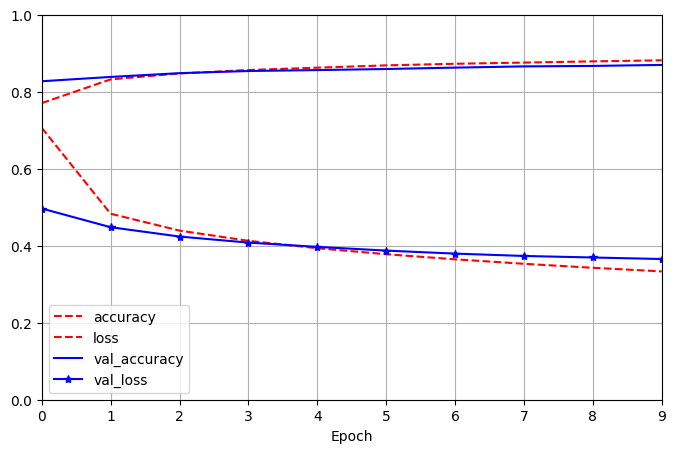

In [31]:
pd.DataFrame(history.history).plot(
    figsize=(8,5), xlim = [0, 9], ylim=[0,1], grid=True, xlabel="Epoch", 
    style = ["r--","r--","b-","b-*"]
)
plt.show()

To continue training - call the fit method again - as keras just continues training where it left off.
Try Hyperparameter tuning if not satisfied with the training results:
- learning rate
- optimizer
- number of layers
- neurons per layer and the types of activation functions to use for each hidden layer
- other hyperparameters - such as the batch_size - defaults to 32. 
- Evaluate on the test set once satisfied: using the evaluate() method. 

In [32]:
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8674 - loss: 0.3880


[0.39376628398895264, 0.8615999817848206]

**Using the model to make predictions:**

Use the model's predict method to make predictions on new instances. Since we don't have actual new instances, we'll just use the first three instances of the test set:

In [33]:
X_new = X_test[:3]

In [34]:
y_proba = model.predict(X_new)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


In [36]:
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.22, 0.  , 0.1 , 0.  , 0.68],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

For each instance, the model estimates one probability per class, from class 0 to class 9. This is similar to the output of the predict_proba() method in scikit lern classifiers. If you only care about the class with the highest estimated probability - use the argmax method to get the highest probability class index for each instance.

In [37]:
import numpy as np

In [38]:
y_pred = y_proba.argmax(axis=-1)

In [39]:
y_pred

array([9, 2, 1], dtype=int64)

In [40]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

Here - the classifier actually classified all 3 images correctly

In [41]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

**Building a Regression MLP using the Sequential API:**
- Let's switch back to the california housing problem - and tackle it usin gthe sam MLP as earlier - with 3 hidden layers composed of 50 neurons each, but this time building it with keras.
- Using the sequential API to build, train, and evaluate, and use a regression MLP is quite similar to classification. 
- Main differences - single output layer has a single neuron - with no activation function and the loss function is the mean squared error - the metric is the RMSE - and we're using an adam optimizer. No flatten layer - and a normalization layer is used instead as the first layer - does the same thing as scikit learn's standardscaler - but it must be fit to the training data using its adapt method before calling the model's fit() method. (Keras has other preprocessing layers)

In [42]:
tf.keras.utils.set_random_seed(42)

In [135]:
X = pd.read_csv(r"C:\Users\blais\Documents\ML\deep_learning\housing_x.csv")
Y = pd.read_csv(r"C:\Users\blais\Documents\ML\deep_learning\housing_y.csv")

In [139]:
X = X.iloc[:, 1:]

In [140]:
X

,bedrooms__ratio,rooms_per_house__ratio,people_per_house__ratio,log__total_bedrooms,log__total_rooms,log__population,log__households,log__median_income,geo__Cluster 0 similarity,geo__Cluster 1 similarity,...,geo__Cluster 6 similarity,geo__Cluster 7 similarity,geo__Cluster 8 similarity,geo__Cluster 9 similarity,cat__ocean_proximity_<1H OCEAN,cat__ocean_proximity_INLAND,cat__ocean_proximity_ISLAND,cat__ocean_proximity_NEAR BAY,cat__ocean_proximity_NEAR OCEAN,remainder__housing_median_age
0,1.846624,-0.866027,-0.330204,1.324114,0.637892,0.456906,1.310369,-1.071522,4.581829e-01,1.241847e-14,...,8.489216e-04,9.770322e-01,2.382191e-08,3.819126e-18,0.0,0.0,0.0,1.0,0.0,1.861119
1,-0.508121,0.024550,-0.253616,-0.252671,-0.063576,-0.711654,-0.142030,1.194712,6.511495e-10,9.579596e-01,...,5.614049e-27,1.260964e-13,1.103491e-01,3.547610e-01,1.0,0.0,0.0,0.0,0.0,0.907630
2,-0.202155,-0.041193,-0.051041,-0.925266,-0.859927,-0.941997,-0.913030,-0.756981,3.432506e-01,4.261141e-15,...,5.641131e-03,7.303265e-01,2.508224e-08,2.669659e-18,0.0,1.0,0.0,0.0,0.0,0.351428
3,-0.149006,-0.034858,-0.141475,0.952773,0.943475,0.670700,0.925373,-0.912253,2.244844e-15,2.704823e-01,...,5.913326e-35,5.201263e-20,1.712982e-03,8.874598e-01,0.0,1.0,0.0,0.0,0.0,-0.919891
4,0.963208,-0.666554,-0.306148,1.437622,1.003590,0.719093,1.481464,0.034537,1.090228e-11,9.422206e-01,...,5.421817e-30,1.048030e-15,2.568824e-02,5.279506e-01,0.0,0.0,0.0,0.0,1.0,0.589800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16507,0.804368,-0.452111,-0.269780,0.465581,0.109720,-0.247054,0.379471,0.648953,1.115293e-10,9.505920e-01,...,1.878046e-28,1.651285e-14,4.776856e-02,3.463930e-01,1.0,0.0,0.0,0.0,0.0,0.987087
16508,-0.192328,0.036792,-0.073741,0.454022,0.477277,0.314542,0.402773,-0.637675,1.409886e-03,1.430917e-03,...,7.663746e-14,9.538119e-06,4.530237e-01,9.507766e-05,0.0,1.0,0.0,0.0,0.0,-0.443146
16509,-0.242492,-0.109987,0.158542,0.824206,0.859552,1.243381,0.889897,0.333540,8.098794e-20,3.501819e-02,...,1.715187e-42,5.158970e-25,5.966953e-06,1.346576e-01,0.0,0.0,0.0,0.0,1.0,-1.237721
16510,0.259775,-0.360937,-0.210332,0.987851,0.811293,0.579462,1.023329,0.377051,4.385614e-10,9.667073e-01,...,2.464809e-27,8.018690e-14,8.956217e-02,3.478114e-01,1.0,0.0,0.0,0.0,0.0,0.669257


In [142]:
Y = Y.iloc[:,1:]

In [143]:
Y

,median_house_value
0,458300.0
1,483800.0
2,101700.0
3,96100.0
4,361800.0
...,...
16507,500001.0
16508,88800.0
16509,148800.0
16510,500001.0


In [144]:
from sklearn.model_selection import train_test_split

In [145]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2)

In [146]:
X_train,X_valid,y_train,y_valid = train_test_split(X_train, y_train, test_size = 0.1)

In [147]:
from sklearn.preprocessing import StandardScaler

In [148]:
scaler = StandardScaler()
y_train_scaled = scaler.fit_transform(y_train)

In [149]:
y_valid_scaled, y_test_scaled = scaler.transform(y_valid), scaler.transform(y_test)

In [153]:
y_train_scaled.shape

(11888, 1)

In [154]:
X_train, X_valid, y_train, y_valid = X_train.values, X_valid.values, y_train_scaled.reshape(y_train_scaled.shape[0],), y_valid_scaled.reshape(y_valid_scaled.shape[0],)

In [155]:
X_test, y_test = X_test.values, y_test_scaled.reshape(y_test_scaled.shape[0],)

In [156]:
tf.keras.utils.set_random_seed(42)

In [157]:
norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])

c:\Users\blais\Documents\ML\venv2\lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [158]:
model = tf.keras.Sequential([
 norm_layer,
 tf.keras.layers.Dense(50, activation="relu"),
 tf.keras.layers.Dense(50, activation="relu"),
 tf.keras.layers.Dense(50, activation="relu"),
 tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
norm_layer.adapt(X_train)

In [159]:
history = model.fit(X_train, y_train_scaled, epochs=20, validation_data=(X_valid, y_valid_scaled))

Epoch 1/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - RootMeanSquaredError: 0.7269 - loss: 0.5377 - val_RootMeanSquaredError: 0.5124 - val_loss: 0.2625
Epoch 2/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - RootMeanSquaredError: 0.5109 - loss: 0.2614 - val_RootMeanSquaredError: 0.4993 - val_loss: 0.2493
Epoch 3/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.5901 - loss: 0.3531 - val_RootMeanSquaredError: 0.4720 - val_loss: 0.2227
Epoch 4/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - RootMeanSquaredError: 0.4955 - loss: 0.2460 - val_RootMeanSquaredError: 0.4718 - val_loss: 0.2226
Epoch 5/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.4606 - loss: 0.2126 - val_RootMeanSquaredError: 0.4562 - val_loss: 0.2081
Epoch 6/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.4499 - loss: 0.2028 - val_RootMeanSquaredError: 0.4478 - val_loss: 0.2006
Epoch 7/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.4444 - los

Issues - Initial features were shit, had to go back to get the good features. 
Scaled the output y-values as well. Feature engineering is definitely important.

In [160]:
model.evaluate(X_test, y_test_scaled)

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.4304 - loss: 0.1857


[0.20019546151161194, 0.4474320709705353]

In [161]:
X_new = X_test[:3]

In [162]:
model.predict(X_new)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


array([[-0.5563381 ],
       [-0.25116068],
       [-0.11687538]], dtype=float32)

In [164]:
y_test_scaled[:3]

array([[-0.50373491],
       [-0.34388067],
       [ 0.08210931]])

In [165]:
y_test[:3]

array([-0.50373491, -0.34388067,  0.08210931])

In [167]:
scaler.inverse_transform(y_test[:3].reshape(-1,1))

array([[147900.],
       [166400.],
       [215700.]])

In [168]:
scaler.inverse_transform(y_test_scaled[:3].reshape(-1,1))

array([[147900.],
       [166400.],
       [215700.]])

In [169]:
scaler.inverse_transform(model.predict(X_new).reshape(-1,1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


array([[141812.22],
       [177130.53],
       [192671.42]], dtype=float32)

Feature engineering- really important
- important to normalize/standardize
- explore r/os to targets
- log_transformation - avoid skewness
- onehot encoding
- also important to normalize targets - if they're numeric